Shape of y :  (70000,)
Shape of X :  (70000, 784)
y to_numeric :  [5 0 4 ... 4 5 6]
Use RBF Kernel with best parameters
acc 0.939
recall 0.936620021181839
precision 0.9396815254553095
F1 0.9379091492076329
Confusion matrix:
[[111   0   0   0   1   0   0   0   1   0]
 [  0 105   1   1   0   0   0   0   0   1]
 [  0   1  83   6   0   0   0   3   0   0]
 [  0   0   2 109   0   0   0   1   3   0]
 [  0   0   3   0  81   0   1   1   0   2]
 [  0   2   0   1   0  75   0   2   0   0]
 [  0   0   1   0   0   1 104   0   1   0]
 [  1   1   0   1   2   0   0  91   0   5]
 [  1   0   1   3   0   1   2   1  79   1]
 [  0   0   0   1   3   0   0   1   0 101]]


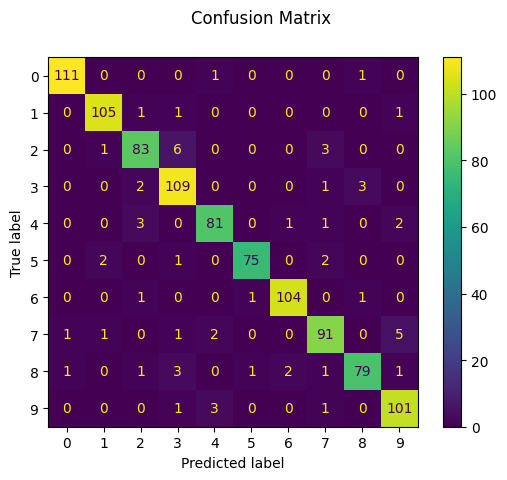

In [1]:
from Dataset import SPAM_import, MNIST_import, IRIS_import
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn import metrics

import numpy as np
from sklearn.datasets import make_blobs
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

def linear_plot(X, y, w=None, b=None):
    
    mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
    colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]
    
    # Plot data 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax.scatter(X[:,0], X[:,1], color=colors, s=150, alpha=0.95, zorder=2)
    
    # Plot boundaries 
    lower_left = np.min([np.min(X[:,0]), np.min(X[:,1])])
    upper_right = np.max([np.max(X[:,0]), np.max(X[:,1])])
    gap = .1*(upper_right-lower_left)
    xplot = np.linspace(lower_left-gap, upper_right+gap, 20)
    if w is not None and b is not None: 
        ax.plot(xplot, (-b - w[0]*xplot)/w[1], color="gray", lw=2, zorder=1)
        ax.plot(xplot, ( 1 -b - w[0]*xplot)/w[1], color="gray", lw=2, ls="--", zorder=1)
        ax.plot(xplot, (-1 -b - w[0]*xplot)/w[1], color="gray", lw=2, ls="--", zorder=1)
        
    
    ax.set_xlim([lower_left-gap, upper_right+gap])
    ax.set_ylim([lower_left-gap, upper_right+gap])
    
    ax.grid(alpha=0.25)
    
def part2data():
    
    np.random.seed(1239)
    
    X = np.zeros((22,2))
    X[0:10,0]  = 1.5*np.random.rand(10) 
    X[0:10,1]  = 1.5*np.random.rand(10)
    X[10:20,0] = 1.5*np.random.rand(10) +  1.75
    X[10:20,1] = 1.5*np.random.rand(10) +  1
    X[20,0] = 1.5
    X[20,1] = 2.25
    X[21,0] = 1.6
    X[21,1] = 0.25
    
    y = np.ones(22)
    y[10:20] = -1 
    y[20] = 1
    y[21] = -1
    
    return X, y

def part3data(N=100, seed=1235):
    
    np.random.seed(seed)
    
    X = np.random.uniform(-1,1,(N,2))
    y = np.array([1 if y-x > 0 else -1 for (x,y) in zip(X[:,0]**2 * np.sin(2*np.pi*X[:,0]), X[:,1])])
    X = X + np.random.normal(0,.1,(N,2))
    
    return X, y

def nonlinear_plot(X, y, clf=None): 
    
    mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    
    colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]
    ax.scatter(X[:,0],X[:,1], marker='o', color=colors, s=100, alpha=0.5)
    
    ax.arrow(-1.25,0,2.5,0, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    ax.arrow(0,-1.25,0,2.5, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    z = np.linspace(0.25,3.5,10)
    
    ax.set_xlim([-1.50,1.50])
    ax.set_ylim([-1.50,1.50])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks([], fontsize=16)
    plt.yticks([], fontsize=16)
    

    if clf: 
        
        clf.fit(X,y)

        x_min = X[:, 0].min()+.00
        x_max = X[:, 0].max()-.00
        y_min = X[:, 1].min()+.00
        y_max = X[:, 1].max()-.00

        colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]

        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.contour(XX, YY, Z, colors=[mycolors["blue"], "gray", mycolors["red"]], linestyles=['--', '-', '--'],
                    levels=[-1.0, 0, 1.0], linewidths=[2,2,2], alpha=0.9)
    
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def plotSearchGrid(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid["C"]), len(grid.param_grid["gamma"]))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid["gamma"])), grid.param_grid["gamma"], rotation=45)
    plt.yticks(np.arange(len(grid.param_grid["C"])), grid.param_grid["C"])
    plt.title('Validation accuracy')
    plt.show()

from IPython.core.display import HTML
HTML("""
<style>
.MathJax nobr>span.math>span{border-left-width:0 !important};
</style>
""")

def printResult(test_y, predict_y):
    print('acc', accuracy_score(test_y, predict_y))
    print('recall', recall_score(test_y, predict_y, average = 'macro'))
    print('precision', precision_score(test_y, predict_y, average = 'macro'))
    print('F1', f1_score(test_y, predict_y, average = 'macro'))



span_dataset = MNIST_import()
#################################
# print('Use LinearSVC')
# model = LinearSVC(C=5, loss='hinge')
# model.fit(span_dataset.train_x, span_dataset.train_y)

# yp = model.predict(span_dataset.val_x)
# printResult(span_dataset.val_y, yp)

#################################
# print('Use RBF Kernel')
# model = SVC(C=5, kernel='rbf')
# model.fit(span_dataset.train_x, span_dataset.train_y)

# yp = model.predict(span_dataset.val_x)
# printResult(span_dataset.val_y, yp)

###### use GridSearchCV to search the best parameters
# it need to be mark because it spend lot of time
# param_range = [2**i for i in range(0, 8)]
# param_grid = {
#     'C': param_range,
#     'gamma': param_range
# }

# svc = SVC(kernel='rbf')  # use RBF kernel
# grid = GridSearchCV(svc, param_grid, cv=2, scoring='accuracy', verbose=2, n_jobs=2)
# grid_result = grid.fit(span_dataset.train_x, span_dataset.train_y)

# print(f"Best accuracy: {grid_result.best_score_},Base paras:{grid_result.best_params_}")
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print(f"Average accuracy: {mean}, std: {stdev}, paras: {param}")

# print("Best C, gamma:", grid.best_params_) # Best C, gamma: {'C': 2, 'gamma': 0.03125}
# print("Best accuracy:", grid.best_score_) # Best accuracy: 0.272
###### use GridSearchCV to search the best parameters

best_C = 10
best_gamma = 0.001
print('Use RBF Kernel with best parameters')
model = SVC(C=best_C, kernel='rbf')
model.fit(span_dataset.train_x, span_dataset.train_y)

yp = model.predict(span_dataset.val_x)
printResult(span_dataset.val_y, yp)

disp = metrics.ConfusionMatrixDisplay.from_predictions(span_dataset.val_y, yp)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()